In [458]:
import numpy as np
import matplotlib.pyplot as plt

Q = pow(10, 5)    # process noise
count_stream = []
count = np.random.normal(0, Q)
if count <= 0:
    count_stream.append(0)
else:
    count_stream.append(count)
while len(count_stream) < 1000:
    count = np.random.normal(count_stream[-1], Q)
    if count >= 0:
        count_stream.append(count)
        
count_stream = np.array(count_stream)

In [459]:
Q = pow(10, 5)    # process noise
count_stream_2 = []

while len(count_stream_2) < 1000:
    count = np.random.normal(0, Q)
    if count >= 0:
        count_stream_2.append(count)
        
count_stream_2 = np.array(count_stream_2)

In [460]:
import math

Q = pow(10, 5)    # process noise
R = pow(10, 6)    # gaussian noise
prior_P = 0    # initial prior error variance
post_P = 0    # initial posterior error variance
prior_x = 0    # initial prior estimate
post_x = 0     # initial posterior estimate
release = []
K = 0    # initial Kalman Gain
alpha = 0.01    # privacy budget
Cp = 0.9
Ci = 0.1
Cd = 0
interval = 1    # initial sampling interval
theta = 10
xi = 0.1
T = 5    # intergral time window
feed_error = [0,0,0,0]
sample_point = [0]
num_sample = 0

def l1_norm(r_list, x_list):
    return np.sum(abs(np.array(r_list) - np.array(x_list)))

def l2_norm(r_list, x_list):
    return np.sqrt(np.sum(pow(np.array(r_list) - np.array(x_list), 2)))

def linf_norm(r_list, x_list):
    return np.amax(abs(np.array(r_list) - np.array(x_list)))

def re(r_list, x_list):
    E = np.sum(abs(np.array(r_list) - np.array(x_list)) / np.maximum(x_list, 1)) / len(x_list)
    return E

def kf_predict(prev_r):
    global prior_x, prior_P
    prior_x = prev_r
    prior_P = post_P + Q
    
def kf_correct(z):
    global K, post_x, post_P
    K = prior_P / (prior_P + R)
    post_x = prior_x + K * (z - prior_x)
    post_P = (1 - K) * prior_P
    
def sample_interval(n):
    global interval
    feed_error.append(abs(post_x - prior_x) / max(post_x, 1))
    delta = Cp * feed_error[-1] + (sum(feed_error[n-1 : n+4]) * Ci) / T    # + Cd * (feed_error[-1] - feed_error[-2]) / (sample_point[-1] - sample_point[-2])
    try:
        interval = max(1, int(interval + theta * (1 - math.exp((delta - xi) / xi))))
    except OverflowError:
        interval = 1

def FAST(input_stream, M):
    global num_sample, K, prior_x, prior_P, post_x, post_P, interval
    feed_error = [0,0,0,0]
    sample_point = [0]
    num_sample = 0
    K = 0
    prior_P = 0   
    post_P = 0    
    prior_x = 0 
    post_x = 0
    interval = int(len(input_stream) / M)
    release.append(input_stream[0])    # let output at k = 0 be the real value of the stream[0]
    for i in range(len(input_stream)):
        kf_predict(release[i])
        
        if i != sample_point[-1] or num_sample > M:
            release.append(prior_x)
        else:
            num_sample += 1
            z = input_stream[i] + np.random.laplace(0, M / alpha)    # noise output
            kf_correct(z)
            if post_x >= 0:
                release.append(post_x)
            else:
                release.append(0)
            sample_interval(len(sample_point))
            sample_point.append(sample_point[-1] + interval)
            
    del release[0]
    
def FAST_2(input_stream):
    global num_sample, K, prior_x, prior_P, post_x, post_P
    num_sample = 0
    K = 0
    prior_P = 0   
    post_P = 0    
    prior_x = 0 
    post_x = 0
    release.append(input_stream[0])    # let output at k = 0 be the real value of the stream[0]
    for i in range(len(input_stream)):
        kf_predict(release[i])
        z = input_stream[i] + np.random.laplace(0, len(input_stream) / alpha)    # noise output
        kf_correct(z)
        if post_x >= 0:
            release.append(post_x)
        else:
            release.append(0)
            
    del release[0]

Result with traditional FAST, sample point = 150
relative error: 0.5163340594260942
L1-norm error: 818882038.4050436
L2-norm error: 35357448.13196527
Linfinity-norm error: 2492266.264095353


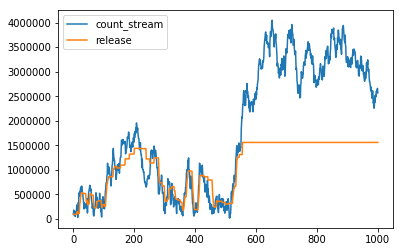

In [461]:
release = []
FAST(count_stream, 150)
relative_error = re(release, count_stream)
print('Result with traditional FAST, sample point = 150')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, count_stream))
print('L2-norm error:', l2_norm(release, count_stream))
print('Linfinity-norm error:', linf_norm(release, count_stream))

plt.plot((np.arange(1000)+1), count_stream)
plt.plot((np.arange(1000)+1), release)
plt.legend(('count_stream', 'release'))
plt.show()

Result with no sampling FAST
relative error: 0.16379467016732088
L1-norm error: 98038767.6762366
L2-norm error: 3942963.933648241
Linfinity-norm error: 463573.84185650153


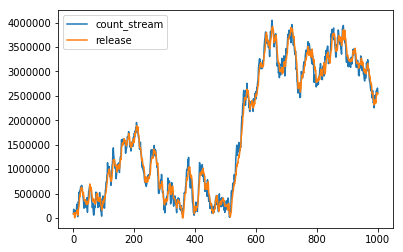

In [462]:
release = []
FAST_2(count_stream)
relative_error = re(release, count_stream)
print('Result with no sampling FAST')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, count_stream))
print('L2-norm error:', l2_norm(release, count_stream))
print('Linfinity-norm error:', linf_norm(release, count_stream))

plt.plot((np.arange(1000)+1), count_stream)
plt.plot((np.arange(1000)+1), release)
plt.legend(('count_stream', 'release'))
plt.show()

Result with only perturbation, epsilon = alpha / 1000
relative error: 0.16557351996955721
L1-norm error: 97718208.13050535
L2-norm error: 4385560.704218938
Linfinity-norm error: 609763.2402497631


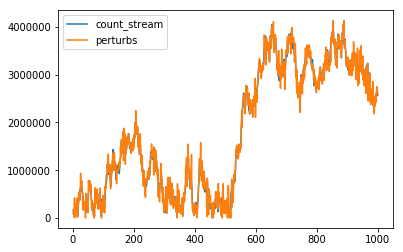

In [463]:
perturbs = []
for c in count_stream:
    perturb = c + np.random.laplace(0, len(count_stream) / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

print('Result with only perturbation, epsilon = alpha / 1000')
print('relative error:', re(perturbs, count_stream))
print('L1-norm error:', l1_norm(perturbs, count_stream))
print('L2-norm error:', l2_norm(perturbs, count_stream))
print('Linfinity-norm error:', linf_norm(perturbs, count_stream))

plt.plot((np.arange(1000)+1), count_stream)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('count_stream', 'perturbs'))
plt.show()

Result with only perturbation, epsilon = alpha
relative error: 0.00018747986676338264
L1-norm error: 101149.68328256393
L2-norm error: 4458.078901946999
Linfinity-norm error: 634.037199802231


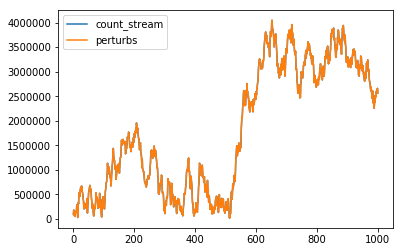

In [464]:
perturbs = []
for c in count_stream:
    perturb = c + np.random.laplace(0, 1 / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

print('Result with only perturbation, epsilon = alpha')
print('relative error:', re(perturbs, count_stream))
print('L1-norm error:', l1_norm(perturbs, count_stream))
print('L2-norm error:', l2_norm(perturbs, count_stream))
print('Linfinity-norm error:', linf_norm(perturbs, count_stream))

plt.plot((np.arange(1000)+1), count_stream)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('count_stream', 'perturbs'))
plt.show()

Result with traditional FAST, sample point = 150
relative error: 5.270370869001099
L1-norm error: 50713657.70470226
L2-norm error: 2088829.2292576216
Linfinity-norm error: 268447.73292763956


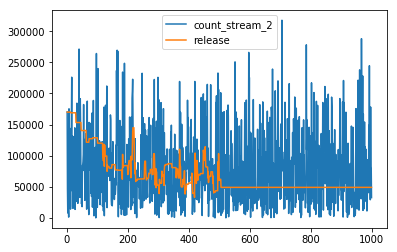

In [465]:
release = []
sample_point = [0]
num_sample = 0
FAST(count_stream_2, 150)
relative_error = re(release, count_stream_2)
print('Result with traditional FAST, sample point = 150')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, count_stream_2))
print('L2-norm error:', l2_norm(release, count_stream_2))
print('Linfinity-norm error:', linf_norm(release, count_stream_2))

plt.plot((np.arange(1000)+1), count_stream_2)
plt.plot((np.arange(1000)+1), release)
plt.legend(('count_stream_2', 'release'))
plt.show()

Result with no sampling FAST
relative error: 5.41669856422104
L1-norm error: 55260518.890801854
L2-norm error: 2175931.2342410814
Linfinity-norm error: 224297.423588965


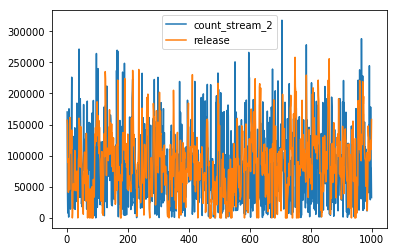

In [466]:
release = []
FAST_2(count_stream_2)
relative_error = re(release, count_stream_2)
print('Result with no sampling FAST')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, count_stream_2))
print('L2-norm error:', l2_norm(release, count_stream_2))
print('Linfinity-norm error:', linf_norm(release, count_stream_2))

plt.plot((np.arange(1000)+1), count_stream_2)
plt.plot((np.arange(1000)+1), release)
plt.legend(('count_stream_2', 'release'))
plt.show()

Result with only perturbation, epsilon = alpha / 1000
relative error: 2.381182762581184
L1-norm error: 72414832.34261584
L2-norm error: 3328382.1225465843
Linfinity-norm error: 603490.6523711784


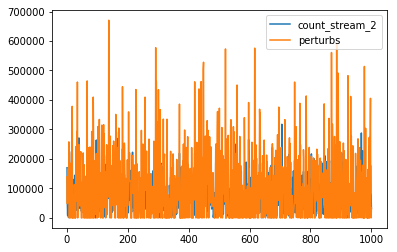

In [467]:
perturbs = []
for c in count_stream_2:
    perturb = c + np.random.laplace(0, len(count_stream_2) / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

print('Result with only perturbation, epsilon = alpha / 1000')    
print('relative error:', re(perturbs, count_stream_2))
print('L1-norm error:', l1_norm(perturbs, count_stream_2))
print('L2-norm error:', l2_norm(perturbs, count_stream_2))
print('Linfinity-norm error:', linf_norm(perturbs, count_stream_2))

plt.plot((np.arange(1000)+1), count_stream_2)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('count_stream_2', 'perturbs'))
plt.show()

Result with only perturbation, epsilon = alpha
relative error: 0.007335838717904626
L1-norm error: 97331.06797709329
L2-norm error: 4423.409864004852
Linfinity-norm error: 638.808609356347


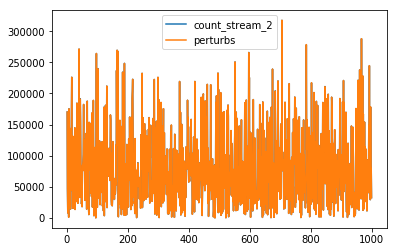

In [468]:
perturbs = []
for c in count_stream_2:
    perturb = c + np.random.laplace(0, 1 / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

print('Result with only perturbation, epsilon = alpha')    
print('relative error:', re(perturbs, count_stream_2))
print('L1-norm error:', l1_norm(perturbs, count_stream_2))
print('L2-norm error:', l2_norm(perturbs, count_stream_2))
print('Linfinity-norm error:', linf_norm(perturbs, count_stream_2))

plt.plot((np.arange(1000)+1), count_stream_2)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('count_stream_2', 'perturbs'))
plt.show()

Result with traditional FAST, sample point = 150
relative error: 0.987126732009441
L1-norm error: 4934580.034269562
L2-norm error: 166364.7164714727
Linfinity-norm error: 24704.700401037506


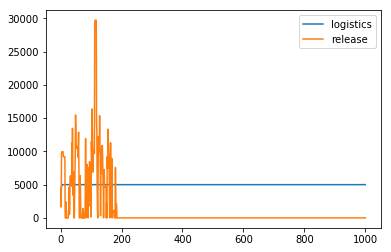

In [469]:
logistics = []
sins = []
A = 5000
b = np.pi / 6
c = np.pi / 2
for i in range(1, 1001):
    logistics.append(A / (1 + np.exp(-i)))
    sins.append(A * np.sin(b*i + c))

logistics = np.array(logistics)
sins = np.array(sins)
    
release = []
sample_point = [0]
num_sample = 0
FAST(logistics, 150)
relative_error = re(release, logistics)
print('Result with traditional FAST, sample point = 150')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, logistics))
print('L2-norm error:', l2_norm(release, logistics))
print('Linfinity-norm error:', linf_norm(release, logistics))

plt.plot((np.arange(1000)+1), logistics)
plt.plot((np.arange(1000)+1), release)
plt.legend(('logistics', 'release'))
plt.show()

Result with no sampling FAST
relative error: 5.9445475668239025
L1-norm error: 29720983.006430186
L2-norm error: 1416166.3322372343
Linfinity-norm error: 215862.01519529853


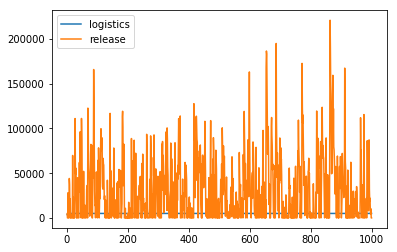

In [470]:
release = []
FAST_2(logistics)
relative_error = re(release, logistics)
print('Result with no sampling FAST')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, logistics))
print('L2-norm error:', l2_norm(release, logistics))
print('Linfinity-norm error:', linf_norm(release, logistics))

plt.plot((np.arange(1000)+1), logistics)
plt.plot((np.arange(1000)+1), release)
plt.legend(('logistics', 'release'))
plt.show()

Result with only perturbation, epsilon = alpha / 1000
relative error: 10.445572664565509
L1-norm error: 52214100.601277396
L2-norm error: 3171170.8162674573
Linfinity-norm error: 685938.7592996754


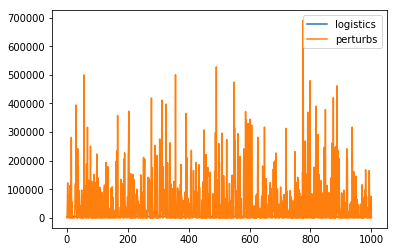

In [471]:
perturbs = []
for c in logistics:
    perturb = c + np.random.laplace(0, len(logistics) / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

print('Result with only perturbation, epsilon = alpha / 1000')
print('relative error:', re(perturbs, logistics))
print('L1-norm error:', l1_norm(perturbs, logistics))
print('L2-norm error:', l2_norm(perturbs, logistics))
print('Linfinity-norm error:', linf_norm(perturbs, logistics))

plt.plot((np.arange(1000)+1), logistics)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('logistics', 'perturbs'))
plt.show()

Result with only perturbation, epsilon = alpha
relative error: 0.020337850579567402
L1-norm error: 101554.78157572898
L2-norm error: 4554.657774747197
Linfinity-norm error: 619.188462521025


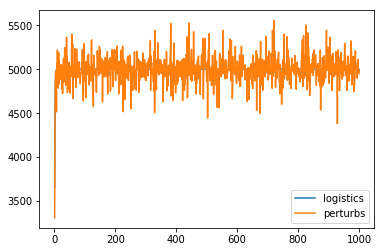

In [472]:
perturbs = []
for c in logistics:
    perturb = c + np.random.laplace(0, 1 / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

print('Result with only perturbation, epsilon = alpha')
print('relative error:', re(perturbs, logistics))
print('L1-norm error:', l1_norm(perturbs, logistics))
print('L2-norm error:', l2_norm(perturbs, logistics))
print('Linfinity-norm error:', linf_norm(perturbs, logistics))

plt.plot((np.arange(1000)+1), logistics)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('logistics', 'perturbs'))
plt.show()

Result with traditional FAST, M = 150
relative error: 2263.887176202729
L1-norm error: 3585222.9353015167
L2-norm error: 136490.41132861827
Linfinity-norm error: 21108.594282356134


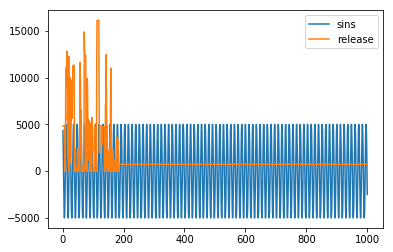

In [473]:
release = []
sample_point = [0]
num_sample = 0
FAST(sins, 150)
relative_error = re(release, sins)
print('Result with traditional FAST, M = 150')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, sins))
print('L2-norm error:', l2_norm(release, sins))
print('Linfinity-norm error:', linf_norm(release, sins))

plt.plot((np.arange(1000)+1), sins)
plt.plot((np.arange(1000)+1), release)
plt.legend(('sins', 'release'))
plt.show()

Result with no sampling FAST
relative error: 18983.818658793934
L1-norm error: 31948860.663550284
L2-norm error: 1496171.243127266
Linfinity-norm error: 216789.56146256783


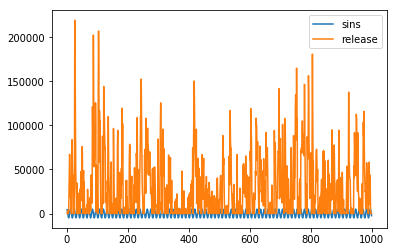

In [474]:
release = []
sample_point = [0]
num_sample = 0
FAST_2(sins)
relative_error = re(release, sins)
print('Result with no sampling FAST')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, sins))
print('L2-norm error:', l2_norm(release, sins))
print('Linfinity-norm error:', linf_norm(release, sins))

plt.plot((np.arange(1000)+1), sins)
plt.plot((np.arange(1000)+1), release)
plt.legend(('sins', 'release'))
plt.show()

Result with only perturbation, epsilon = alpha / 1000
relative error: 60122.23703587968
L1-norm error: 102137040.89595695
L2-norm error: 4562171.890103047
Linfinity-norm error: 640078.6833366728


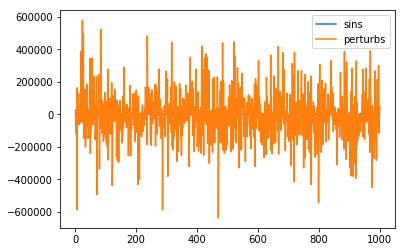

In [475]:
perturbs = []
for c in sins:
    perturbs.append(c + np.random.laplace(0, len(sins) / alpha))
    
print('Result with only perturbation, epsilon = alpha / 1000')
print('relative error:', re(perturbs, sins))
print('L1-norm error:', l1_norm(perturbs, sins))
print('L2-norm error:', l2_norm(perturbs, sins))
print('Linfinity-norm error:', linf_norm(perturbs, sins))

plt.plot((np.arange(1000)+1), sins)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('sins', 'perturbs'))
plt.show()

Result with only perturbation, epsilon = alpha
relative error: 57.7988993082057
L1-norm error: 101046.01652294572
L2-norm error: 4447.344457788088
Linfinity-norm error: 745.4090580859611


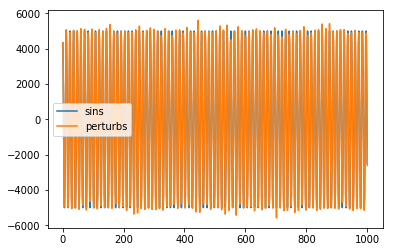

In [476]:
perturbs = []
for c in sins:
    perturbs.append(c + np.random.laplace(0, 1 / alpha))
    
print('Result with only perturbation, epsilon = alpha')
print('relative error:', re(perturbs, sins))
print('L1-norm error:', l1_norm(perturbs, sins))
print('L2-norm error:', l2_norm(perturbs, sins))
print('Linfinity-norm error:', linf_norm(perturbs, sins))

plt.plot((np.arange(1000)+1), sins)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('sins', 'perturbs'))
plt.show()

In [43]:
# import csv

# counts = []

# with open('C:\\Users\\user\Downloads\\region_data.csv') as csvfile:
#     rows = csv.reader(csvfile)
    
#     for row in rows:
#         counts.append(row)

In [44]:
# counts = counts[3:]
# for i in range(len(counts)):
#     counts[i] = counts[i][1:]
#     counts[i] = list(map(int, counts[i]))

In [374]:
releases = []
alpha = 0.01 * 150
for count in counts:
    release = []
    FAST(count, 150)
    releases.append(release)

In [375]:
import csv

with open('output.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['', 'timestamp', 'region', 'real_count', 'release_count'])
    for i in range(len(releases[0]) * len(releases)):
        writer.writerow([i, (i % 673), int(i / 673), counts[int(i / 673)][(i % 673)], releases[int(i / 673)][(i % 673)]])

Result with FAST, M =  150 epsilon =  1.5
relative error: 0.6246884584953784
L1-norm error: 17097.230153158394
L2-norm error: 858.3762379563335
Linfinity-norm error: 145.47626821442344


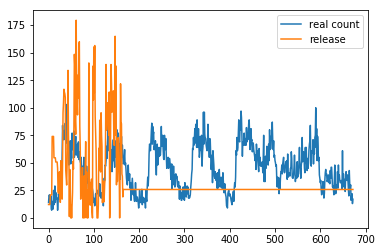

In [376]:
print('Result with FAST, M = ', 150, 'epsilon = ', alpha)
print('relative error:', re(releases[0], counts[0]))
print('L1-norm error:', l1_norm(releases[0], counts[0]))
print('L2-norm error:', l2_norm(releases[0], counts[0]))
print('Linfinity-norm error:', linf_norm(releases[0], counts[0]))

plt.plot((np.arange(len(counts[0]))), counts[0])
plt.plot((np.arange(len(counts[0]))), releases[0])
plt.legend(('real count', 'release'))
plt.show()

Result with no sampling FAST, epsilon =  6.73
relative error: 0.9060328944373447
L1-norm error: 21400.374951835132
L2-norm error: 1054.4407170552577
Linfinity-norm error: 212.479792413104


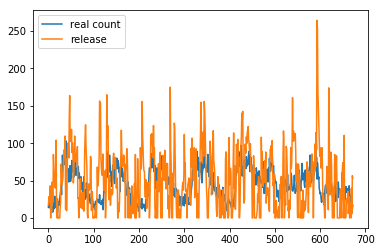

In [366]:
alpha = 0.01 * len(counts[0])
release = []
FAST_2(counts[0])

print('Result with no sampling FAST, epsilon = ', alpha)
print('relative error:', re(release, counts[0]))
print('L1-norm error:', l1_norm(release, counts[0]))
print('L2-norm error:', l2_norm(release, counts[0]))
print('Linfinity-norm error:', linf_norm(release, counts[0]))

plt.plot((np.arange(len(counts[0]))), counts[0])
plt.plot((np.arange(len(counts[0]))), release)
plt.legend(('real count', 'release'))
plt.show()

Result with only perturbation, epsilon =  0.01
relative error: 0.9008832426146154
L1-norm error: 21311.815641588546
L2-norm error: 1140.982663961781
Linfinity-norm error: 454.451942812478


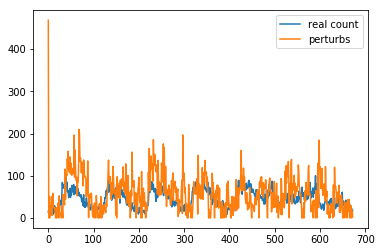

In [367]:
import numpy as np

perturbs = []
alpha = 0.01
for i in range(len(counts[0])):
    perturb = counts[0][i] + np.random.laplace(0, 1 / alpha)
    if i > 3 and np.mean(perturbs[-3:]) != 0:
        perturb = (perturb + np.sum(perturbs[-3:])) / 4
    if perturb >= 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)
    
print('Result with only perturbation, epsilon = ', alpha)
print('relative error:', re(perturbs, counts[0]))
print('L1-norm error:', l1_norm(perturbs, counts[0]))
print('L2-norm error:', l2_norm(perturbs, counts[0]))
print('Linfinity-norm error:', linf_norm(perturbs, counts[0]))

plt.plot((np.arange(len(counts[0]))), counts[0])
plt.plot((np.arange(len(counts[0]))), perturbs)
plt.legend(('real count', 'perturbs'))
plt.show()